In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit

params = np.empty(shape=(10,2))
params[:,0] = np.random.randn(10)
params[:,1] = 5
params

array([[ 2.38859947,  5.        ],
       [ 0.67525885,  5.        ],
       [-2.51192256,  5.        ],
       [ 0.46448372,  5.        ],
       [-1.24983979,  5.        ],
       [ 0.24167575,  5.        ],
       [-1.50699535,  5.        ],
       [-0.21864975,  5.        ],
       [ 0.77639812,  5.        ],
       [-2.66157744,  5.        ]])

In [2]:
SMALL_SIZE = 4
MEDIUM_SIZE = 5
BIGGER_SIZE = 6

mpl.rc('font', size=SMALL_SIZE)          
mpl.rc('axes', titlesize=SMALL_SIZE)    
mpl.rc('axes', labelsize=MEDIUM_SIZE)   
mpl.rc('xtick', labelsize=SMALL_SIZE)   
mpl.rc('ytick', labelsize=SMALL_SIZE)    
mpl.rc('legend', fontsize=SMALL_SIZE)    
mpl.rc('figure', titlesize=BIGGER_SIZE)  

In [3]:
@jit(nopython=True)
def g_policy(array,k):
    mask = array==np.max(array)
    seq = np.arange(k)[mask]
    return np.random.choice(seq,1)

def e_policy(array,k,e):

    flag = np.random.choice((True,False),p=(1-e,e))

    if flag:
        mask = array==np.max(array)
        seq = np.arange(k)[mask]
        return np.random.choice(seq,1)
    else:
        seq = np.arange(k)
        return np.random.choice(seq,1)
    

class kBandit():

    def __init__(self,params,n,k,policy,**kwargs):
        self.p_reward = np.copy(params)
        self.policy = policy
        self.steps = n
        self.k = k
        self.kwargs = kwargs
        self.value = np.zeros(self.k)
        self.visits = np.ones(self.k)

    def action(self):
        return self.policy(self.value,self.k,**self.kwargs)

    def reward(self,i):
        return self.p_reward[i,1]*np.random.randn()+self.p_reward[i,0]

    def update_step(self,reward,i):
        self.value[i] = self.value[i]+(reward-self.value[i])/self.visits[i]
        self.visits[i] += 1
    
    def simulation(self):
        sim = np.empty(shape=self.steps)
        act = np.empty(shape=self.steps)
        for j in range(self.steps):
            i = self.action()
            act[j] = i
            reward = self.reward(i)
            sim[j] = reward
            self.update_step(reward,i)
        value = self.value
        self.value = np.zeros(self.k)
        self.visits = np.ones(self.k)
        return act,sim,value
    
    def param_update(self):
        self.p_reward[:,0] = self.p_reward[:,0]+np.random.randn(10)*0.1

    def nstat_simulation(self):
        sim = np.empty(shape=self.steps)
        act = np.empty(shape=self.steps)
        best = np.empty(shape=self.steps)
        for j in range(self.steps):
            best[j] = np.argmax(self.p_reward[:,0])
            i = self.action()
            act[j] = i
            reward = self.reward(i)
            sim[j] = reward
            self.update_step(reward,i)
            self.param_update()
        value = self.value
        self.value = np.zeros(self.k)
        self.visits = np.ones(self.k)
        return act,sim,value,best


In [4]:
it = 1000
k = 5000
tenbandit = kBandit(params,k,10,g_policy)

sense_matrix = np.empty(shape=(it,k))
for p in range(it):
    act,_,value = tenbandit.simulation()
    sense_matrix[p,:] = (act==np.argmax(params[:,0]))

ts_greedy = sense_matrix.sum(axis=0)/it

In [5]:
it = 1000
k = 5000
tenbandit = kBandit(params,k,10,e_policy,e=0.05)

sense_matrix = np.empty(shape=(it,k))
for p in range(it):
    act,_,value = tenbandit.simulation()
    sense_matrix[p,:] = (act==np.argmax(params[:,0]))

ts_e05 = sense_matrix.sum(axis=0)/it

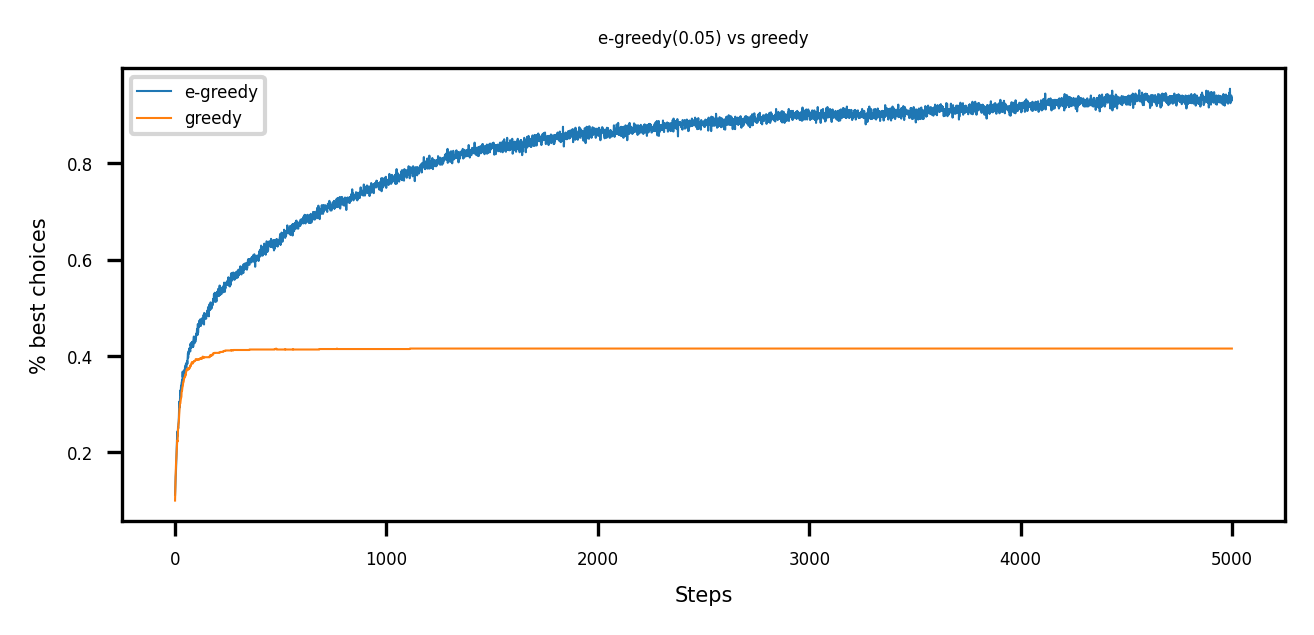

In [6]:
fig = plt.figure(figsize=(5,2),dpi=300)
plt.plot(ts_e05,linewidth=0.5,label="e-greedy")
plt.plot(ts_greedy,linewidth=0.5,label="greedy")
plt.xlabel("Steps")
plt.ylabel("% best choices")
plt.title("e-greedy(0.05) vs greedy")
plt.legend()

In [7]:
it = 1000
k = 5000

sense_matrix = np.empty(shape=(it,k))
for p in range(it):
    tenbandit = kBandit(params,k,10,g_policy)
    act,_,_,best = tenbandit.nstat_simulation()
    sense_matrix[p,:] = (act==best)

ts_greedy = sense_matrix.sum(axis=0)/it

In [8]:
it = 1000
k = 5000

sense_matrix = np.empty(shape=(it,k))
for p in range(it):
    tenbandit = kBandit(params,k,10,e_policy,e=0.05)
    act,_,_,best = tenbandit.nstat_simulation()
    sense_matrix[p,:] = (act==best)

ts_e05 = sense_matrix.sum(axis=0)/it

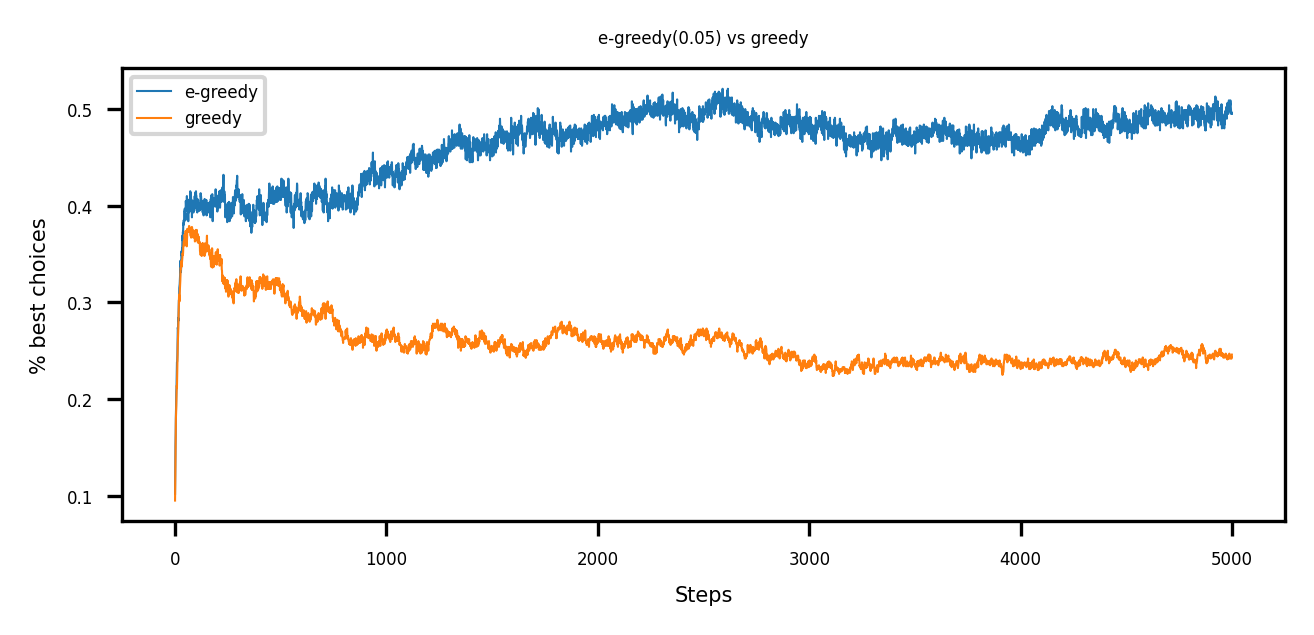

In [9]:
fig = plt.figure(figsize=(5,2),dpi=300)
plt.plot(ts_e05,linewidth=0.5,label="e-greedy")
plt.plot(ts_greedy,linewidth=0.5,label="greedy")
plt.xlabel("Steps")
plt.ylabel("% best choices")
plt.title("e-greedy(0.05) vs greedy")
plt.legend()